In [3]:
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import numpy as np
from scipy.constants import golden
from sklearn.linear_model import LinearRegression
import ipywidgets as widgets
import uuid
import os
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import pytz
import random
from collections import OrderedDict 
from matplotlib import animation
import collections

In [4]:
today = datetime.datetime.today()
# Select your local timezone to get the right date when running the notebook
localtimezone = pytz.timezone("US/Pacific")
today = today.astimezone(localtimezone)
print(f"{today.year}-{today.month:02d}-{today.day:02d}")

2020-04-26


In [5]:
filename = f"https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-{today.year}-{today.month:02d}-{today.day:02d}.xlsx"

In [6]:
df = pd.read_excel(filename)

In [7]:
df = df[::-1]
df.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,continentExp
13210,2020-03-21,21,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
13209,2020-03-22,22,3,2020,1,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
13208,2020-03-23,23,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa
13207,2020-03-24,24,3,2020,0,1,Zimbabwe,ZW,ZWE,14439018.0,Africa
13206,2020-03-25,25,3,2020,0,0,Zimbabwe,ZW,ZWE,14439018.0,Africa


In [8]:
datecol = df.columns[0]
cases = df.columns[4]
country = df.columns[7]
datecol, cases, country

('dateRep', 'cases', 'geoId')

In [9]:
def logarithmic_curve(x, a, c, d):
    return a / (1 + np.exp(-c * (x - d)))

In [10]:
def exp_curve(x, a, b):
    return a*np.exp(b*x)

In [11]:
def covid_graphs(selectedcountry, threshold=10, image_width=5, show_deaths=False, save_figure=False):
    nrows = 2
    ncols = 2
    markersize = 10
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(image_width*ncols, image_width*nrows))
    fig.tight_layout(pad=3.0)
    confirmed = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['cases']
    confirmed_daily = confirmed.values
    confirmed_cumsum = confirmed.cumsum().values
    deaths = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['deaths']
    if confirmed_daily.sum() < 10:
        return 0
    
    if show_deaths:
        axs[0, 0].bar(np.arange(0, len(deaths)), deaths.cumsum().values, color='#c9c9c9', label='cumulative deaths')
        axs[0, 0].text(0.65, 0.9, f"Deaths: {deaths.sum()}", transform=axs[0, 0].transAxes)
        axs[0, 1].bar(np.arange(0, len(deaths)), deaths.cumsum().values, color='#c9c9c9', label='cumulative deaths')
        axs[0, 1].text(0.65, 0.9, f"Deaths: {deaths.sum()}", transform=axs[0, 1].transAxes)
    
    axs[0, 0].plot(np.arange(0, len(confirmed_daily)), confirmed_daily, color='#fc5e03', label='daily')
    axs[0, 0].plot(np.arange(0, len(confirmed_cumsum)), confirmed_cumsum, color='b', label='cumulative')

    axs[0, 0].plot(np.argmax(confirmed_daily), max(confirmed_daily), ".",  markersize=markersize, color='r', label=f"Max cases in one day ({max(confirmed_daily)})")

    axs[0, 0].set_yscale('linear')
    axs[0, 0].set_xlabel('Days since first infection')
    axs[0, 0].text(0.65, 0.95, f"Infections: {confirmed_daily.sum()}", transform=axs[0, 0].transAxes)
    axs[0, 0].legend()
    axs[0, 0].set_title('Infections')
    
    axs[0, 1].set_yscale('log')
    axs[0, 1].plot(np.arange(0, len(confirmed_daily)), confirmed_daily, color='#fc5e03', label='daily')
    axs[0, 1].plot(np.arange(0, len(confirmed_cumsum)), confirmed_cumsum, color='b', label='cumulative')
    axs[0, 1].text(0.65, 0.95, f"Infections: {confirmed_daily.sum()}", transform=axs[0, 1].transAxes)
    axs[0, 1].plot(np.argmax(confirmed_daily), max(confirmed_daily), ".",  markersize=markersize, color='r', label=f"Max cases in one day ({max(confirmed_daily)})")

    axs[0, 1].set_xlabel('Days since first infection')
    axs[0, 1].legend()
    axs[0, 1].set_title('Infections (logarithmic scale)')
    
    growth_rate = confirmed_daily/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift().values
    growth_rate_indices = df[(df[country] == selectedcountry) & (df['cases'] >= 1)].index
    growth_ratedf = df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases']/df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['cases'].shift()
    rolling_mean = growth_ratedf.rolling(window=3).mean()
    lr = LinearRegression()
    days_gr = [(df.loc[idx, datecol] - df[(df[country] == selectedcountry) & (df['cases'] >= 1)]['dateRep'].min()).days for idx in df[(df[country] == selectedcountry) & (df['cases'] >= 1)].index]
    days_gr = np.array(days_gr)
    lr.fit(days_gr[1:].reshape(-1,1), growth_rate[1:].reshape(-1,1))
    growth_trend = lr.predict(days_gr[1:].reshape(-1,1))
    
    axs[1, 0].bar(np.arange(0, len(growth_rate)), growth_rate, color='#bababa', label='daily rate')
    axs[1, 0].plot(np.arange(0, len(rolling_mean.values)), rolling_mean.values, color='#fc5e03', linewidth=2, label='3-day average')
    axs[1, 0].plot(np.arange(0, len(days_gr[1:])), growth_trend, color='#0000ff', label='trend')
    axs[1, 0].hlines(1.0, 0, len(days_gr[1:]), color='#000000', ls="--", lw=1)

    if (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate))) < 0.85:
        y_text = 0.85 - (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
    else:
        y_text = 0.85

    axs[1, 0].text(-0.5, y_text, "No growth", size=9)
    axs[1, 0].text(.67, 0.82, f"Current = {growth_rate[-1]:.2f}", size=10, transform=axs[1, 0].transAxes)
    axs[1, 0].text(.67, 0.79, f"3-day avg= {rolling_mean.values[-1]:.2f}", size=10, transform=axs[1, 0].transAxes)
    
    if rolling_mean.values[-1] > 1/np.log10(2):
        axs[1, 0].text(.62, 0.76, f"New cases double every day", size=10, transform=axs[1, 0].transAxes) 
    elif rolling_mean.values[-1] > 1:
        axs[1, 0].text(.57, 0.76, f"New cases double every {np.log10(2)/np.log10(rolling_mean.values[-1]):.0f} day{'s' if np.log10(2)/np.log10(rolling_mean.values[-1]) > 1 else ''}", size=10, transform=axs[1, 0].transAxes)
    
    axs[1, 0].set_xticks(np.arange(0, len(df[(df[country] == selectedcountry) & (df['cases'] >= 1)][cases]), 10))
    axs[1, 0].set_xlabel('Days since first infection')
    
    axs[1, 0].set_ylim(bottom=0, top=np.nanmean(growth_rate)+2*np.nanstd(growth_rate))
    axs[1, 0].legend(loc='upper right')
    axs[1, 0].set_title('Growth factor')
    
    if len(confirmed_cumsum) > 10:
        c = -1
        c = -1
        myfunction = logarithmic_curve
        x = np.arange(0, len(confirmed_cumsum))
        try:
            logistic_params, covariance = curve_fit(myfunction, x, confirmed_cumsum, p0=[0.5, 0.5, 0.5])
            a, c, d = logistic_params
        except Exception as e:
            print(e)

        axs[1, 1].plot(np.arange(0, len(confirmed_cumsum)), confirmed_cumsum, ".", markersize=8, label="Reported cases")

        if c < 0 or d < 0:
            myfunction = exp_curve
            logistic_params, covariance = curve_fit(myfunction, x, confirmed_cumsum, p0=[0.5, 0.5])
                    
        confirmed_pred = myfunction(np.arange(0, len(confirmed_cumsum)), *logistic_params)
        r2 = r2_score(confirmed_cumsum, confirmed_pred)
        axs[1, 1].text(0.2, 0.3, f"$R^2$={r2:.4f}", transform=axs[1, 1].transAxes)

        days = 30
        x = np.arange(0, len(days_gr) + days)
        y = myfunction(x, *logistic_params)
        axs[1, 1].plot([len(confirmed_daily), len(confirmed_daily)], [0, max(y)], color='k', ls=':')
        axs[1, 1].plot(x, y, color='#fc5e03', label=f"Fitted {'logistic' if myfunction == logarithmic_curve else 'exponentiao'} function")
        
        if confirmed_cumsum[-1] < y[-1]:
            text_x = 0.15
            text_y = 0.15
            if myfunction == logarithmic_curve:
                text_x = 0.55
                text_y = 0.05

            axs[1, 1].text(text_x, text_y+0.05, f"Total predicted cases\nin a month from today: "
                           f"{int(y[-1])}", transform=axs[1, 1].transAxes)

        axs[1, 1].fill_between(x[-days:], confirmed_cumsum[-1], y[-days:],
                               facecolor="none", hatch="/", edgecolor="b", linewidth=0.0,
                              label='Predicted increase')
    
    axs[1, 1].set_xlabel('Days since first infection')
    axs[1, 1].legend(loc='upper left')
    axs[1, 1].set_title('Evolution (prediction)')

    
    country_name = df[df[country] == selectedcountry]['countriesAndTerritories'].values[0]
    date_str = today.strftime("%B %d, %Y")
    plt.suptitle(f"COVID-19 evolution in {country_name}\n{date_str}", y=1.025, size=15)
    
    if save_figure:
        filename = f"{selectedcountry}_{today.year}-{today.month:02d}-{today.day:02d}_{uuid.uuid4().hex}.png"
        destination_folder = os.path.expanduser(r"~\Documents\COVID-19")
        if not os.path.isdir(destination_folder):
            try:
                os.mkdir(destination_folder)
            except Exception as e:
                print(e)
        plt.savefig(os.path.join(destination_folder, filename),
                    dpi=300, bbox_inches='tight')
        print(f"file saved as: {os.path.join(destination_folder, filename)}")

In [12]:
countries = df[['countriesAndTerritories', country, 'cases']].groupby(['countriesAndTerritories', country], as_index=False)['cases'].sum().values

countries = countries[countries[:,2].argsort()[::-1]]

countries = [(f"{a} ({c})", b) for a, b, c in countries]

%matplotlib inline
style = {'description_width': 'initial'}
output = widgets.interact(covid_graphs,
                          selectedcountry=widgets.Dropdown(options=countries,
                                                           value=countries[0][1],
                                                           description='Country (total):',
                                                           style=style),
                          threshold=widgets.IntSlider(10, 5, 500, 5), 
                          image_width=widgets.IntSlider(6, 3, 10, 1),
                          show_deaths=widgets.Checkbox(False, disabled=False),
                          save_figure=widgets.Checkbox(False, disabled=False))

interactive(children=(Dropdown(description='Country (total):', options=(('United_States_of_America (939053)', …

C:\ProgramData\Anaconda3\envs\ds36\lib\site-packages\ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in greater
  


Text(0.5, 1.01, 'Growth factor evolution')

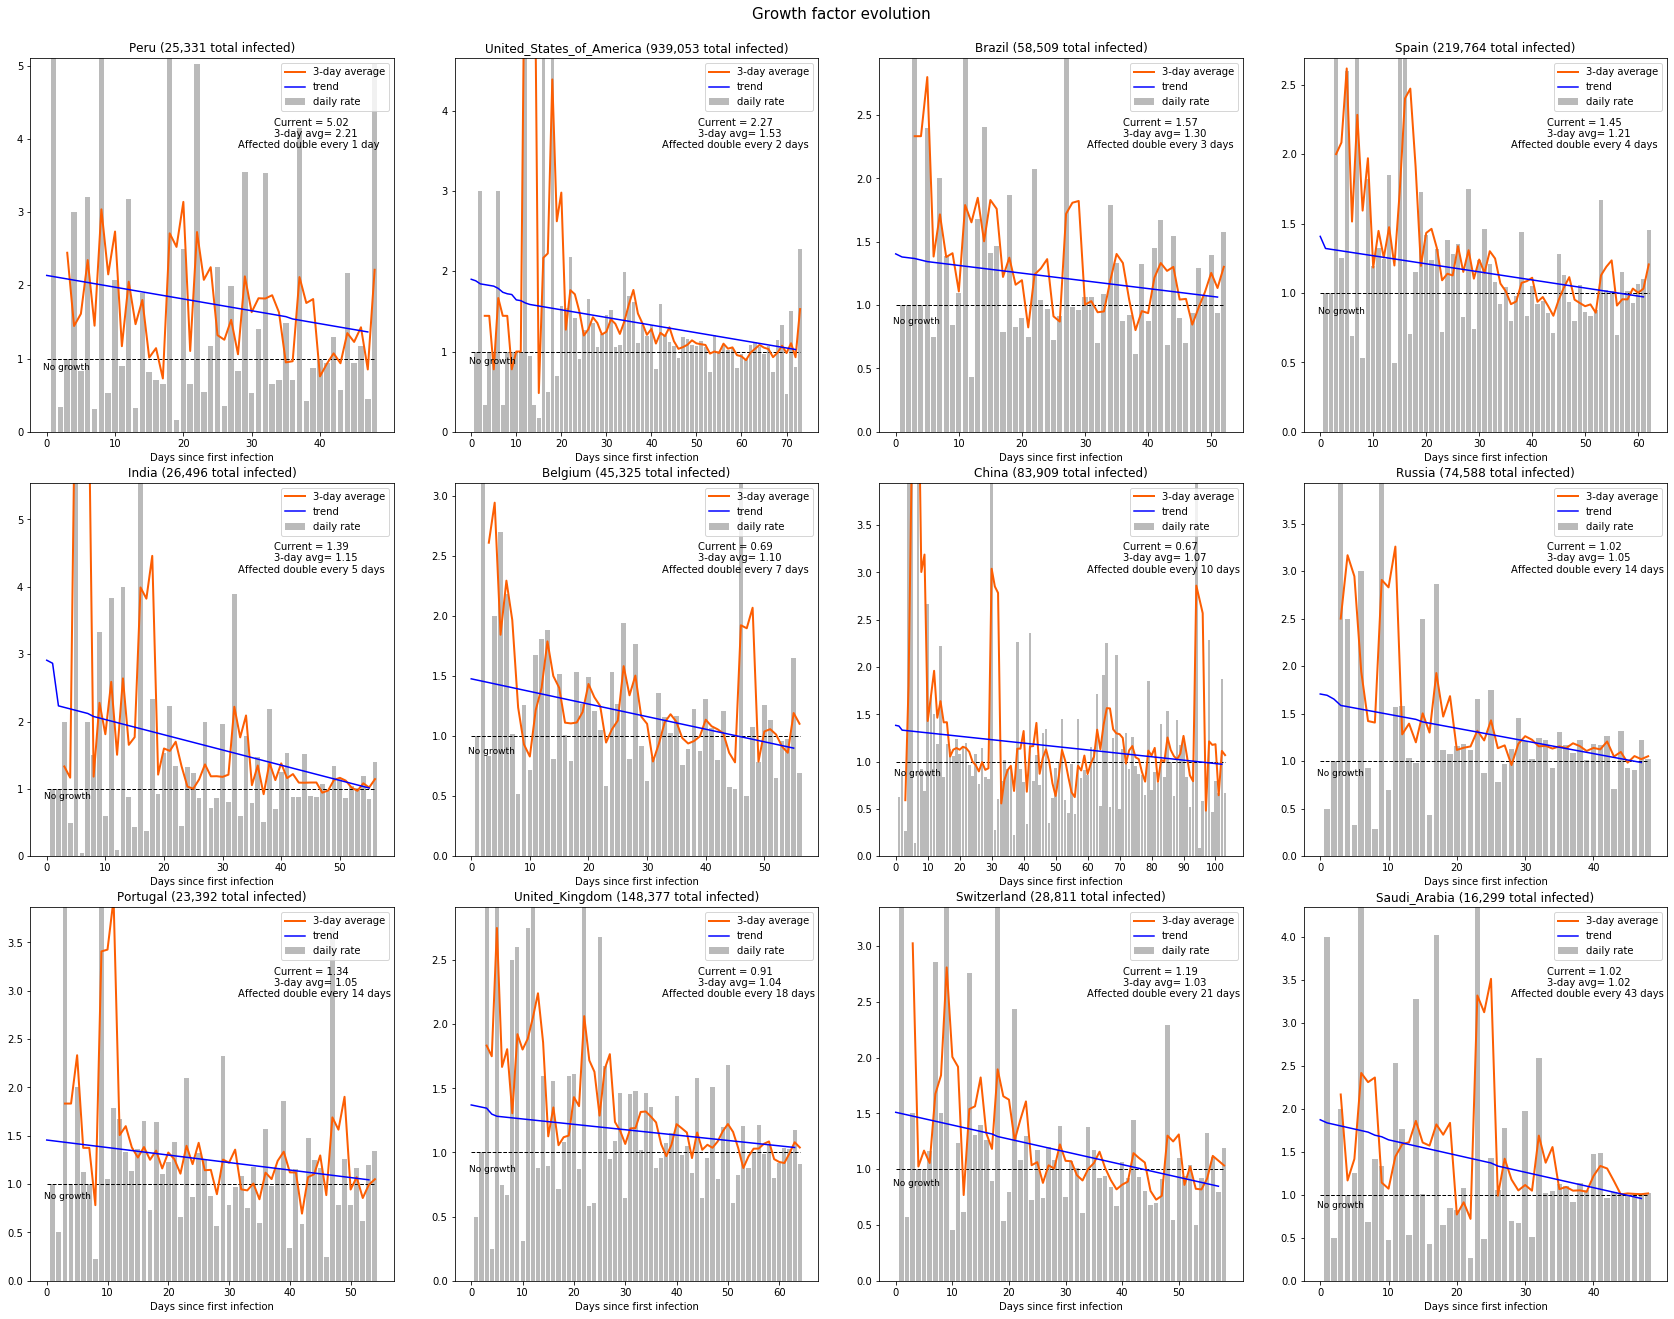

In [13]:
# Only display countries with at least 15,000 cases:
min_number_cases = 15000
growth_rates = []
for selectedcountry in df[country].unique():
    confirmed = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]['cases']
    if len(confirmed) > 1:
        confirmed_daily = confirmed.values
        confirmed_cumsum = confirmed.cumsum().values
        growth_rate = confirmed_daily/confirmed.shift().values
        growth_ratedf = confirmed/confirmed.shift()
        rolling_mean = growth_ratedf.rolling(window=3).mean()
        if (confirmed_cumsum[-1] > min_number_cases) \
        and \
        (len(growth_rate > 3) \
        and \
        len(rolling_mean.values) > 1) and rolling_mean.values[-1] > 1.0:
            
            growth_rates.append((selectedcountry, growth_rate[-1], rolling_mean.values[-1]))

growth_rates.sort(key = lambda x: x[2], reverse=True)

relevant_countries = np.array(growth_rates)[:,0].tolist()
nrows = ncols = int(np.ceil(len(relevant_countries)**0.5))

image_width = 6
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(image_width*ncols, image_width*nrows))
fig.tight_layout(pad=3.0)

df.fillna(0, inplace=True)
for i, selectedcountry in enumerate(relevant_countries):
    from scipy import stats
    
    countrydf = df[(df['cases'] >= 1) & (df[country]==selectedcountry)]  
    confirmed = countrydf['cases']
    
    confirmed_daily = confirmed.values
    confirmed_cumsum = confirmed.cumsum().values
    deaths = countrydf['deaths']
    growth_rate = confirmed_daily/confirmed.shift().values

    growth_ratedf = confirmed/confirmed.shift()
    rolling_mean = growth_ratedf.rolling(window=3).mean()
    
    lr = LinearRegression()
    days_gr = [(df.loc[idx, datecol] - countrydf['dateRep'].min()).days for idx in countrydf.index]
    days_gr = np.array(days_gr)
    lr.fit(days_gr[1:].reshape(-1,1), np.clip(growth_rate[1:], 0, np.mean(growth_rate[1:])*2*np.std(growth_rate[1:])).reshape(-1,1))
    growth_trend = lr.predict(days_gr[1:].reshape(-1,1))

    axs[i//nrows, (i%nrows)%ncols].bar(np.arange(0, len(growth_rate)), growth_rate, color='#bababa', label='daily rate')
    axs[i//nrows, (i%nrows)%ncols].plot(np.arange(0, len(rolling_mean.values)), rolling_mean.values, color='#fc5e03', linewidth=2, label='3-day average')
    axs[i//nrows, (i%nrows)%ncols].plot(np.arange(0, len(days_gr[1:])), growth_trend, color='#0000ff', label='trend')
    axs[i//nrows, (i%nrows)%ncols].hlines(1.0, 0, len(days_gr[1:]), color='#000000', ls="--", lw=1)

    if (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate))) < 0.85:
        y_text = 0.85 - (9/(np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
    else:
        y_text = 0.85

    axs[i//nrows, (i%nrows)%ncols].text(-0.5, y_text, "No growth", size=9)
    axs[i//nrows, (i%nrows)%ncols].text(.67, 0.82, f"Current = {growth_rate[-1]:.2f}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    axs[i//nrows, (i%nrows)%ncols].text(.67, 0.79, f"3-day avg= {rolling_mean.values[-1]:.2f}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    
    if rolling_mean.values[-1] > 1/np.log10(2):
        axs[i//nrows, (i%nrows)%ncols].text(.62, 0.76, f"Affected double every day", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes) 
    elif rolling_mean.values[-1] > 1:
        axs[i//nrows, (i%nrows)%ncols].text(.57, 0.76, f"Affected double every {np.log10(2)/np.log10(rolling_mean.values[-1]):.0f} day{'s' if np.log10(2)/np.log10(rolling_mean.values[-1]) > 1 else ''}", size=10, transform=axs[i//nrows, (i%nrows)%ncols].transAxes)
    
    axs[i//nrows, (i%nrows)%ncols].set_xticks(np.arange(0, len(confirmed), 10))
    axs[i//nrows, (i%nrows)%ncols].set_xlabel('Days since first infection')
    
    axs[i//nrows, (i%nrows)%ncols].set_ylim(bottom=0, top=min(np.nanmean(growth_rate)*3, np.nanmean(growth_rate)+2*np.nanstd(growth_rate)))
    axs[i//nrows, (i%nrows)%ncols].legend(loc='upper right')
    kountry = df[df[country]==selectedcountry]['countriesAndTerritories'].unique()[-1]
    axs[i//nrows, (i%nrows)%ncols].set_title(f'{kountry} ({confirmed_cumsum[-1]:,.0f} total infected)')
    
for i in range(len(relevant_countries), nrows**2):
    fig.delaxes(axs[i//nrows, (i%nrows)%ncols])
                                                                                   
plt.suptitle("Growth factor evolution", y=1.01, size=15)                          
                                            
# Uncomment the following lines to save the image on your hard disk                                            
# filename = f"Growth_rates_{today.year}-{today.month:02d}-{today.day:02d}_{uuid.uuid4().hex}.png"
# destination_folder = os.path.expanduser(r"~\Documents\COVID-19")
# plt.savefig(os.path.join(destination_folder, filename), dpi=300, bbox_inches='tight')
# print(f"file saved as: {os.path.join(destination_folder, filename)}")